Scanning ./plot/ for *_POSCAR files...
Processed ID 1: 0_POSCAR_mattersim_opt -> 0.5069 eV/atom
Processed ID 2: 1_12_POSCAR_mattersim_opt -> 0.4454 eV/atom
Processed ID 3: 1_1_POSCAR_mattersim_opt -> 0.4683 eV/atom
Processed ID 4: 1_24_POSCAR_mattersim_opt -> 0.4856 eV/atom
Processed ID 5: 1_26_POSCAR_mattersim_opt -> 0.6884 eV/atom
Processed ID 6: 1_29_POSCAR_mattersim_opt -> 0.2942 eV/atom
Processed ID 7: 1_35_POSCAR_mattersim_opt -> 1.1335 eV/atom
Processed ID 8: 1_39_POSCAR_mattersim_opt -> 0.2943 eV/atom
Processed ID 9: 1_3_POSCAR_mattersim_opt -> 0.4379 eV/atom
Processed ID 10: 1_46_POSCAR_mattersim_opt -> 0.0037 eV/atom
Processed ID 11: 1_47_POSCAR_mattersim_opt -> 0.2919 eV/atom
Processed ID 12: 1_63_POSCAR_mattersim_opt -> 0.7061 eV/atom
Processed ID 13: 1_67_POSCAR_mattersim_opt -> 0.6235 eV/atom
Processed ID 14: 1_72_POSCAR_mattersim_opt -> 0.2944 eV/atom
Processed ID 15: 1_83_POSCAR_mattersim_opt -> 0.2333 eV/atom
Processed ID 16: 1_84_POSCAR_mattersim_opt -> 0.5833 eV/atom

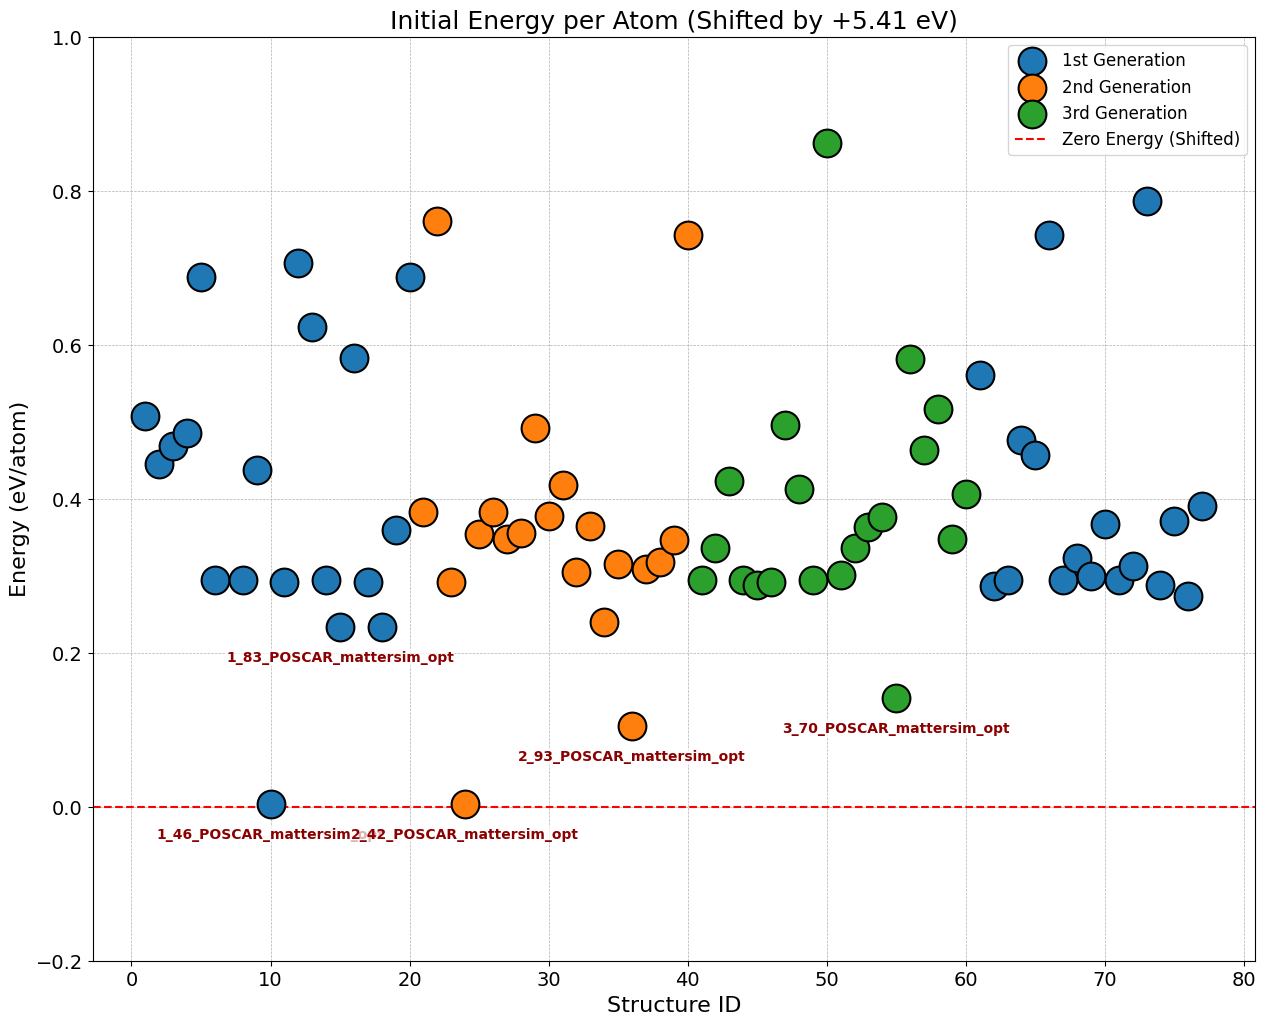


Graph saved to: ./plot/energy_graph_labeled.png
Data table saved to: ./plot/energy_data.txt


In [4]:
import os
import glob
import matplotlib.pyplot as plt
from ase import io
from matplotlib.ticker import MaxNLocator
from mattersim.forcefield import MatterSimCalculator

# ==========================================
#        USER DEFINED VARIABLES
# ==========================================
INPUT_DIR = "./plot/"
OUTPUT_DIR = "./plot/"

# --- Y-Axis Limits ---
MIN_Y = -0.2
MAX_Y = 1.0

# --- Energy Calculation ---
ENERGY_SHIFT = 5.410  # Shift value (eV)

# --- Annotation Settings ---
SHOW_LABELS = True    # Set to False to hide names
NUM_TO_LABEL = 5      # How many "lowest energy" structures to label?

# ==========================================

def process_structures(input_folder, output_folder):
    
    # 1. Setup Output Directory
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 2. Get list of files
    search_path = os.path.join(input_folder, "*_POSCAR*")
    all_files = sorted(glob.glob(search_path))
    
    structure_data = [] 
    count = 1

    print(f"Scanning {input_folder} for *_POSCAR files...")

    # 3. Loop through files and Calculate
    for file_path in all_files:
        filename = os.path.basename(file_path)
        
        if os.path.isdir(file_path):
            continue

        try:
            atoms = io.read(file_path)
            atoms.calc = MatterSimCalculator()
            
            total_energy = atoms.get_potential_energy()
            num_atoms = len(atoms)
            
            # Calculate Raw Energy
            raw_energy_per_atom = total_energy / num_atoms
            
            # --- APPLY SHIFT ---
            energy_per_atom = raw_energy_per_atom + ENERGY_SHIFT
            
            # Determine group ID
            group_id = 1
            if 1 <= count <= 20:
                group_id = 1 
            elif 21 <= count <= 40:
                group_id = 2 
            elif 41 <= count <= 60:
                group_id = 3 
            
            structure_data.append({
                "id": count,
                "filename": filename,
                "energy_per_atom": energy_per_atom,
                "group_id": group_id
            })
            print(f"Processed ID {count}: {filename} -> {energy_per_atom:.4f} eV/atom")
            count += 1
            
        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

    if not structure_data:
        print("No valid structures found.")
        return

    plot_data = [d for d in structure_data if d['group_id'] in (1, 2, 3)]
    
    if not plot_data:
        print("No structures found in range 1-60.")
        return

    # 4. Generate and Save Plot
    plt.figure(figsize=(15, 12))
    
    groups_config = [
        {'id': 1, 'color': 'tab:blue', 'label': '1st Generation'},
        {'id': 2, 'color': 'tab:orange', 'label': '2nd Generation'},
        {'id': 3, 'color': 'tab:green', 'label': '3rd Generation'},
    ]

    # Plot Scatter Points
    for group in groups_config:
        group_data = [d for d in plot_data if d['group_id'] == group['id']]
        
        if group_data:
            ids = [d['id'] for d in group_data]
            energies = [d['energy_per_atom'] for d in group_data]
            
            plt.scatter(
                ids,
                energies,
                s=400,
                facecolors=group['color'],
                edgecolors='black',
                linewidths=1.5,
                zorder=3,
                label=group['label']
            )

    # --- ANNOTATION LOGIC (Show names of low energy structures) ---
    if SHOW_LABELS:
        # Sort by energy (lowest first)
        sorted_structures = sorted(plot_data, key=lambda x: x['energy_per_atom'])
        
        # Take the top N lowest
        lowest_structures = sorted_structures[:NUM_TO_LABEL]
        
        print("\n--- Low Energy Structures identified ---")
        for item in lowest_structures:
            print(f"Labeling: {item['filename']} (E = {item['energy_per_atom']:.4f})")
            
            # Add text to plot
            plt.text(
                x=item['id'], 
                y=item['energy_per_atom'] - 0.03, # Slightly below the dot
                s=item['filename'], 
                fontsize=10, 
                ha='center', 
                va='top', 
                fontweight='bold',
                color='darkred',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
            )

    plt.axhline(y=0, color='r', linestyle='--', label='Zero Energy (Shifted)')
    
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f'Initial Energy per Atom (Shifted by +{ENERGY_SHIFT} eV)', fontsize=18)
    plt.xlabel('Structure ID', fontsize=16)
    plt.ylabel('Energy (eV/atom)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Use User Defined Limits
    plt.ylim(MIN_Y, MAX_Y)
    
    plt.legend(loc='upper right', fontsize=12)
    
    graph_path = os.path.join(output_folder, 'energy_graph_labeled.png')
    plt.savefig(graph_path, dpi=300)
    plt.show()
    plt.close()
    print(f"\nGraph saved to: {graph_path}")

    # 5. Save Data to Text File
    txt_path = os.path.join(output_folder, 'energy_data.txt')
    with open(txt_path, 'w') as f:
        f.write(f"{'ID':<5} {'Group':<7} {'Filename':<30} {'Energy (eV/atom)':<20}\n")
        f.write("-" * 62 + "\n")
        for data in structure_data:
            f.write(f"{data['id']:<5} {data['group_id']:<7} {data['filename']:<30} {data['energy_per_atom']:<20.6f}\n")
            
    print(f"Data table saved to: {txt_path}")

if __name__ == "__main__":
    process_structures(INPUT_DIR, OUTPUT_DIR)

Loading standard structure from: ./standard_/Si_POSCAR
SOAP descriptor initialized and standard vector calculated.

Scanning ./16 atoms calculation/plot for *_POSCAR files...
No.   Filename                            Energy          Similarity
----------------------------------------------------------------------
1     1_0_POSCAR_mattersim_opt            0.3490 eV      0.9856
2     1_10_POSCAR_mattersim_opt           0.2922 eV      0.9847
3     1_11_POSCAR_mattersim_opt           0.4211 eV      0.9956
4     1_12_POSCAR_mattersim_opt           0.2922 eV      0.9911
5     1_13_POSCAR_mattersim_opt           0.3575 eV      0.9968
6     1_14_POSCAR_mattersim_opt           0.3210 eV      0.9973
7     1_15_POSCAR_mattersim_opt           1.0541 eV      0.9602
8     1_16_POSCAR_mattersim_opt           0.4603 eV      0.9964
9     1_17_POSCAR_mattersim_opt           0.2036 eV      0.9955
10    1_18_POSCAR_mattersim_opt           0.8935 eV      0.9423
11    1_19_POSCAR_mattersim_opt           0.4

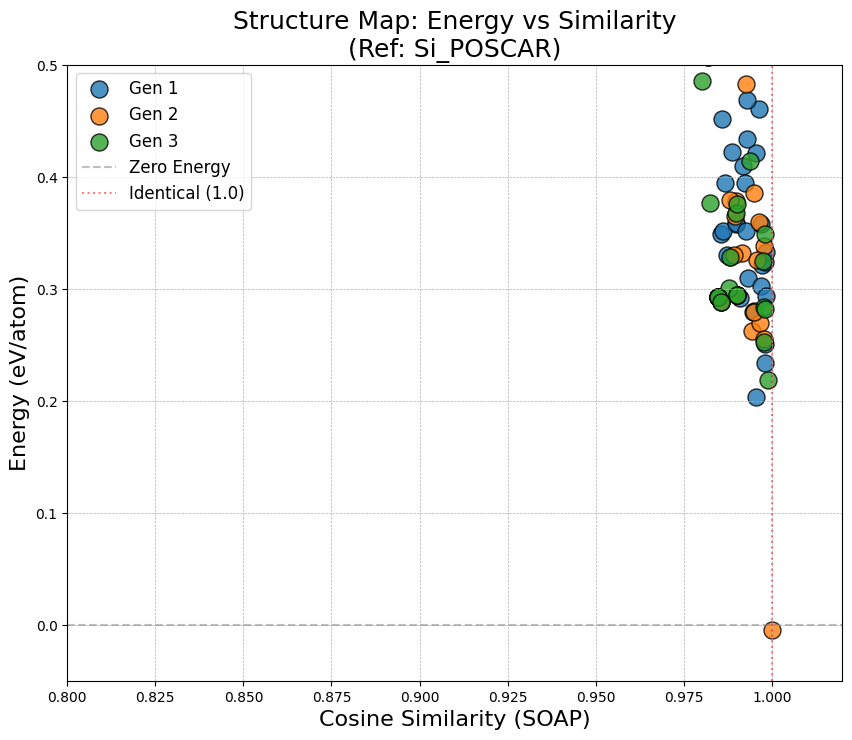


Graph saved to: ./16 atoms calculation/plot/energy_vs_similarity.png
Data table saved to: ./16 atoms calculation/plot/structure_analysis_data.txt


In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from ase import io
from scipy.spatial.distance import cosine
from dscribe.descriptors import SOAP
from mattersim.forcefield import MatterSimCalculator

# ==========================================
#        USER DEFINED VARIABLES
# ==========================================

# --- Paths ---
INPUT_DIR = "./16 atoms calculation/plot"
OUTPUT_DIR = "./16 atoms calculation/plot"
STANDARD_FILE = "./standard_/Si_POSCAR"

# --- Axis Scale Settings (ADJUST HERE) ---
# 1. Energy Axis (Y-Axis)
ENERGY_MIN = -0.05
ENERGY_MAX = 0.5

# 2. Cosine Similarity Axis (X-Axis)
# Similarity is usually between 0 and 1 (1.0 = identical)
SIM_MIN = 0.80
SIM_MAX = 1.02

# --- Energy Calculation Settings ---
ENERGY_SHIFT = 5.410

# --- SOAP Settings ---
SOAP_R_CUT = 6.0
SOAP_N_MAX = 4
SOAP_L_MAX = 4
SOAP_SIGMA = 0.5

# ==========================================

def get_soap_descriptor(atoms_list, r_cut, n_max, l_max, sigma):
    species = set()
    for atoms in atoms_list:
        species.update(atoms.get_chemical_symbols())
    
    return SOAP(
        species=sorted(list(species)),
        periodic=True,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max,
        sigma=sigma,
        average='inner'
    )

def process_structures():
    # 1. Setup Output Directory
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    # 2. Load Standard Structure
    print(f"Loading standard structure from: {STANDARD_FILE}")
    try:
        standard_atoms = io.read(STANDARD_FILE)
    except FileNotFoundError:
        print(f"Error: Standard file not found at {STANDARD_FILE}")
        return

    # 3. Initialize SOAP
    soap = get_soap_descriptor(
        [standard_atoms], 
        SOAP_R_CUT, 
        SOAP_N_MAX, 
        SOAP_L_MAX, 
        SOAP_SIGMA
    )
    
    std_vector = soap.create(standard_atoms).flatten()
    print("SOAP descriptor initialized and standard vector calculated.")

    # 4. Scan Files
    search_path = os.path.join(INPUT_DIR, "*_POSCAR*")
    all_files = sorted(glob.glob(search_path))
    
    structure_data = [] 
    count = 1

    print(f"\nScanning {INPUT_DIR} for *_POSCAR files...")
    print(f"{'No.':<5} {'Filename':<35} {'Energy':<15} {'Similarity'}")
    print("-" * 70)

    for file_path in all_files:
        filename = os.path.basename(file_path)
        
        if os.path.abspath(file_path) == os.path.abspath(STANDARD_FILE):
            continue
            
        if os.path.isdir(file_path):
            continue

        try:
            atoms = io.read(file_path)
            
            # --- Energy Calculation ---
            atoms.calc = MatterSimCalculator()
            total_energy = atoms.get_potential_energy()
            num_atoms = len(atoms)
            
            raw_energy_per_atom = total_energy / num_atoms
            energy_per_atom = raw_energy_per_atom + ENERGY_SHIFT
            
            # --- Cosine Similarity Calculation ---
            target_vector = soap.create(atoms).flatten()
            # Similarity = 1 - Distance
            cos_sim = 1 - cosine(std_vector, target_vector)

            # --- Group Logic ---
            group_id = 1
            if 1 <= count <= 20:
                group_id = 1 
            elif 21 <= count <= 40:
                group_id = 2 
            elif 41 <= count <= 60:
                group_id = 3 
            
            structure_data.append({
                "id": count,
                "filename": filename,
                "energy_per_atom": energy_per_atom,
                "cosine_similarity": cos_sim,
                "group_id": group_id
            })
            
            # Print to Output Console
            print(f"{count:<5} {filename:<35} {energy_per_atom:.4f} eV      {cos_sim:.4f}")
            count += 1
            
        except Exception as e:
            print(f"Skipping {filename}: {e}")
            continue

    if not structure_data:
        print("No valid structures found.")
        return

    plot_data = [d for d in structure_data if d['group_id'] in (1, 2, 3)]
    
    if not plot_data:
        print("No structures found in range 1-60.")
        return

    # 5. Generate and Save Plot (Single Marker Scatter)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green'}
    labels = {1: 'Gen 1', 2: 'Gen 2', 3: 'Gen 3'}

    # Loop to plot points
    for gid in [1, 2, 3]:
        group_items = [d for d in plot_data if d['group_id'] == gid]
        if not group_items:
            continue
            
        # Extract X (Similarity) and Y (Energy)
        energies = [d['energy_per_atom'] for d in group_items]
        similarities = [d['cosine_similarity'] for d in group_items]
        
        # Plot single marker for each structure
        ax.scatter(similarities, energies, s=150, color=colors[gid], edgecolors='black', 
                   marker='o', label=labels[gid], alpha=0.8)

    # Labels and Limits
    ax.set_xlabel('Cosine Similarity (SOAP)', fontsize=16)
    ax.set_ylabel('Energy (eV/atom)', fontsize=16)
    
    ax.set_xlim(SIM_MIN, SIM_MAX)
    ax.set_ylim(ENERGY_MIN, ENERGY_MAX)
    
    # Reference Lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Zero Energy')
    ax.axvline(x=1.0, color='red', linestyle=':', alpha=0.5, label='Identical (1.0)')

    ax.set_title(f'Structure Map: Energy vs Similarity\n(Ref: {os.path.basename(STANDARD_FILE)})', fontsize=18)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(fontsize=12, loc='upper left')
    
    graph_path = os.path.join(OUTPUT_DIR, 'energy_vs_similarity.png')
    plt.savefig(graph_path, dpi=300)
    plt.show()
    plt.close()
    print(f"\nGraph saved to: {graph_path}")

    # 6. Save Data to Text File
    txt_path = os.path.join(OUTPUT_DIR, 'structure_analysis_data.txt')
    with open(txt_path, 'w') as f:
        header = f"{'ID':<5} {'Group':<7} {'Filename':<30} {'Energy (eV/atom)':<20} {'Similarity':<20}\n"
        f.write(header)
        f.write("-" * len(header) + "\n")
        for data in structure_data:
            line = (f"{data['id']:<5} {data['group_id']:<7} {data['filename']:<30} "
                    f"{data['energy_per_atom']:<20.6f} {data['cosine_similarity']:<20.6f}\n")
            f.write(line)
            
    print(f"Data table saved to: {txt_path}")

if __name__ == "__main__":
    process_structures()